# Model-Predictive Path Integral Control Example

In [3]:
%load_ext autoreload
%autoreload 2

## Imports and Parameters

In [4]:
import time
from utils import * # imports integrators and other useful things
from system import * # imports system dynamics and objective
from MPPI import MPPI # imports controller
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

###################
# System parameters
# x0 = np.array([0,0])
x0 = np.array([0,0,1.7,0,0])
xd = np.array([0,0,1.4,0,0])
del_t = 0.05
# dyn = lambda x, u: double_int_1D(x,u) 
dyn = lambda x, u: SLIP_walker(x,u) 

######################
# Objective parameters
w_sz = 10; ov = 0.5;
R = 20.0*np.diag([1.0, 1.0])
Q = 1.0*np.diag([0.0, 10.0, 100.0, 10.0, 0.0])
u0 = np.array([0.0, 0.0])
xloc = 0.0; a = 0.005; b = .15; # 1D potential well params
var_ind = 0 # variable index for diffusion
w = -5000; # weight on rattling
obj = lambda x, u: SLIP_objective(x, u, a, b, xloc, var_ind, del_t, w, w_sz, ov, xd, Q, R)

#######################
# Controller parameters
noise_mean = np.array([0.0, 0.0])
noise_var = 0.1*np.diag([1.0,1.0])
samp_num = 50 # 100 was good for diff
predictive_horizon = 40 # 100 was good for diff
simulation_length = 1000 # 1000 was good for diff
Temp = 1.0

## Initialize Controller

In [5]:
controller = MPPI(dyn, obj, x0, u0, K=samp_num, N=predictive_horizon, dt=del_t, lamb=Temp, noise_mu=noise_mean, noise_sigma=noise_var)

## Main Loop

In [6]:
tic = time.time()
xlist = []
ulist = []
costlist = []
for i in range(simulation_length):
    u_star = controller.step(x0)[:,0]
    x = integrate(dyn,x0,u_star,del_t)
    x0 = np.copy(x)
    xlist.append(x0)
    ulist.append(u_star)
    costlist.append(np.mean(controller.cost_total))
    if (i+1) % int(simulation_length/4.0) == 0:
        print(str(int(100.0*((float(i+1)/float(simulation_length)))))+"% complete. Time elapsed: "+str(np.round(time.time()-tic,2))+"s.")
xtraj = np.array(xlist).T
utraj = np.array(ulist).T

25% complete. Time elapsed: 35.85s.
50% complete. Time elapsed: 71.0s.
75% complete. Time elapsed: 106.36s.
100% complete. Time elapsed: 140.85s.


## Plot

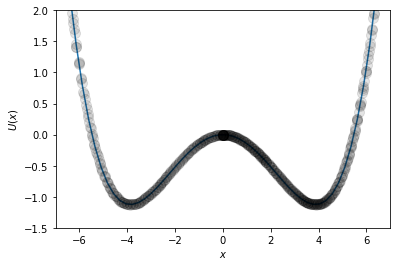

In [12]:
fun = lambda x: double_well_1D(x, a, b, xloc, var_ind)
xv = np.linspace(-1.1*np.max(np.abs(xtraj[0])),1.1*np.max(np.abs(xtraj[0])),100)
yv = np.array([fun([x]) for x in xv])
pot_traj = np.array([fun([x]) for x in xtraj[0]])
plt.figure()
plt.plot(xv,yv,zorder=0)
skip = 1
plt.scatter(xtraj[0,::skip],pot_traj[::skip],c='k',alpha=0.1,zorder=1,s=100)
# plt.xlim([-1.1*np.max(np.abs(xtraj[0])),1.1*np.max(np.abs(xtraj[0]))])
plt.xlim([-7,7])
plt.ylim([-1.5,2])
plt.xlabel(r'$x$')
plt.ylabel(r'$U(x)$')
plt.show()

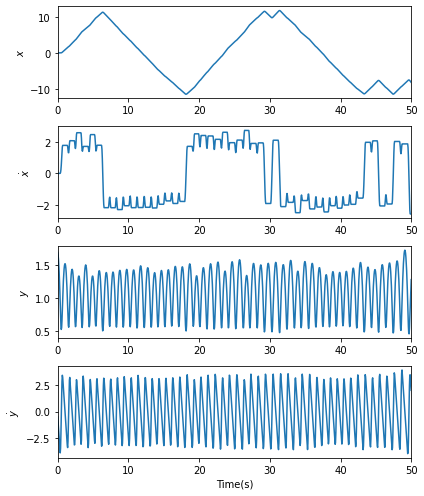

In [8]:
tvec = np.linspace(0,del_t*xtraj.shape[1],xtraj.shape[1])
lims = [tvec[0],tvec[-1]]
# lims = [110,170]

plt.figure(figsize=(6,7))
label_list = [r'$x$',r'$\dot{x}$',r'$y$',r'$\dot{y}$',r'$u_1$',r'$u_2$']
for i in range(1,5):
    plt.subplot(4,1,i)
    plt.plot(tvec,xtraj[i-1])
    plt.xlim(lims)
    plt.ylabel(label_list[i-1])
# plt.subplot(6,1,5)
# plt.plot(tvec,utraj[0])
# plt.xlim(lims)
# plt.ylabel(label_list[4])
# plt.subplot(6,1,6)
# plt.plot(tvec,utraj[1])
# plt.xlim(lims)
# plt.ylabel(label_list[5])
plt.xlabel('Time(s)')
plt.tight_layout()
plt.show()

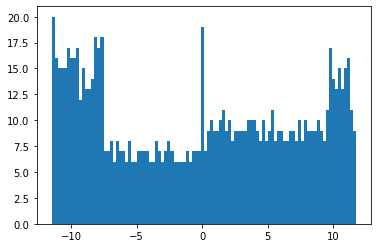

In [9]:
plt.figure()
plt.hist(xtraj[0],bins=100)
# plt.xlim([-np.max(np.abs(xtraj[0])),np.max(np.abs(xtraj[0]))])
plt.show()

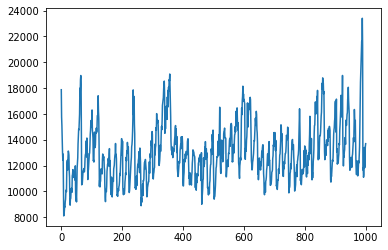

In [10]:
plt.figure()
plt.plot(costlist)
plt.show()

In [ ]:
plt.close('all')